# Advanced Lane Finding Project


## Overview

### Goals
Accurate and robust detection of lane lines, lane curvature, and vehicle position with visual display output.  

###  Implementation Outline
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Contents
1. `camera_cal` - camera calibration images. 
2. `test_images` - source images for single frame pipeline tests.
3. `output_images` - single frame pipeline test output images. 
4. `project_video.mp4` - pipeline test source video.
5. `output_video.mp4` - pipeline test output video.
6. `README.md` - writeup and documentation.
7. `advanced_lane_finding.ipynb` - implementation code + documentation.

### Libraries
External libraries used in this project.

In [1]:
import numpy as np
import cv2
import os
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt
%matplotlib inline

### Pyplot Defaults Setup

In [2]:
plt.rcParams['figure.figsize'] = [14,8]
plt.rcParams['figure.frameon'] = False
plt.rcParams['figure.edgecolor'] = 'none'  
plt.rcParams['figure.facecolor'] = 'none' 
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['ytick.labelright'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.labeltop'] = False
plt.rcParams['axes.grid'] = False
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.subplot.hspace'] = 0.01
plt.rcParams['figure.subplot.wspace'] = 0.01
plt.rcParams['image.interpolation'] = 'bilinear'

## Camera Calibration

### Load Calibration Images
There are 20 RGB, 720x1280 pixel, JPEG, calibration images.  
Each image contains a 7x10 square celled chessboard pattern with 6x9 inner corners.

In [3]:
CALIB_DIR = './camera_cal/'; fpaths = os.listdir(CALIB_DIR)
imlist = [cv2.imread(CALIB_DIR+fp,cv2.IMREAD_COLOR) for fp in fpaths]
print('image count:',len(imlist)); print('image shape:',imlist[0].shape)

image count: 20
image shape: (720, 1280, 3)


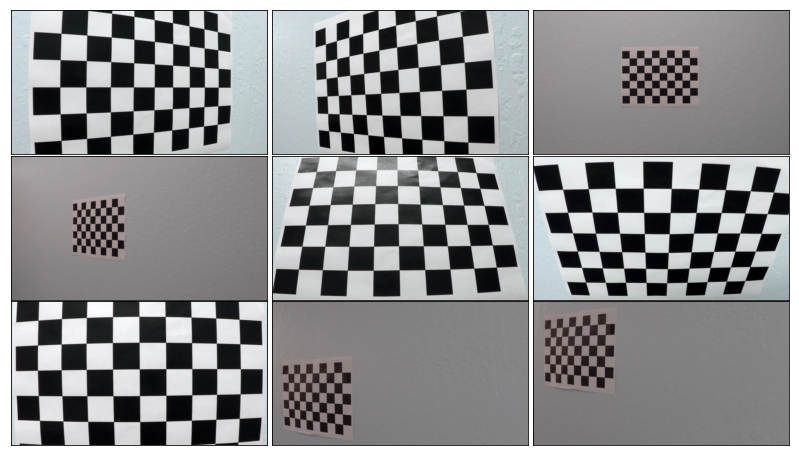

In [4]:
axlist = plt.subplots(3,3)[1].ravel()
for ax,im in zip(axlist,imlist):
    ax.imshow(im)

### Find Chessboard Inner Corners
- The function `cv2.findChessboardCorners()` looks for the 6x9 chessboard pattern inner corners. It's not able to match all calibration images. 
- The corner positions computed with `cv2.findChessboardCorners()` are said to be low percision, altough in practice they're useable as-is. We perform an additional, more computationaly expensive, percision positioning step via `cv2.cornersSubPix()` in an effort to maximize calibration quality.
-  We'll use the green channel to approximate a grayscale image where such input is required.

In [5]:
CBOARD_SHAPE = (9,6)
FINDCB_FLAGS = cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_NORMALIZE_IMAGE
SUBPIX_CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
imgpts = []; mrkdimgs=[]
for img in imlist:
    ret, corners = cv2.findChessboardCorners(img[...,1],CBOARD_SHAPE, flags=FINDCB_FLAGS)        
    if ret is True:
        corners = cv2.cornerSubPix(img[...,1],corners,(11,11),(-1,-1),SUBPIX_CRITERIA) 
        imgpts.append(corners); mrkdimgs.append(img.copy())
print('number of full pattern matches:', len(imgpts))

number of full pattern matches: 17


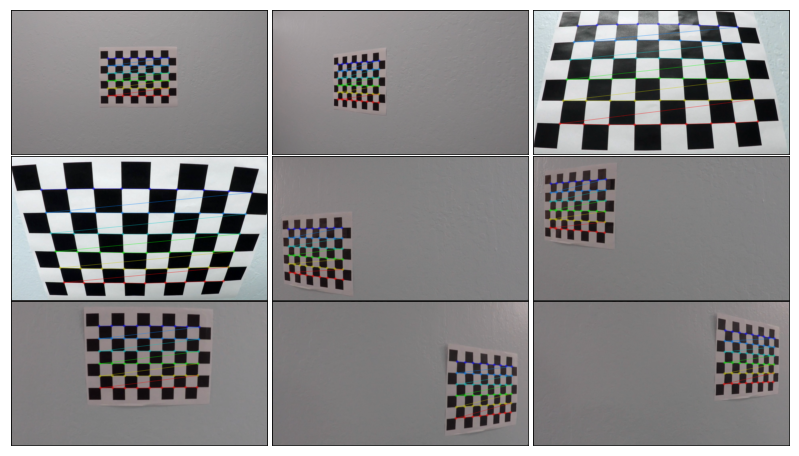

In [6]:
axlist = plt.subplots(3,3)[1].ravel()
for img,pts,ax in zip(mrkdimgs,imgpts,axlist):
        img = cv2.drawChessboardCorners(img, CBOARD_SHAPE, pts, True)
        ax.imshow(img)

### Calibration and Distortion Correction
`cv2.calibrateCamera` and `cv2.getOptimalNewCameraMatrix` are used to perform image registration between the found pattern corner points and an estimate of their supposed positions in an undistorted image. The function computes a matching 3x3 composite transformation matrix (concatenation of rotation, scale perspective, etc transforms) which best describes the pattern distortion in supplied images. The inverse of the distortion transformation matrix is the correction matrix.  

#### Correction Output Calculation
Distortion correction is applied by matrix multiplication of the correction matrix against image coordinate vectors, and then interpolating and copying the values to produce the corrected image. Subsequently, the image is cropped to remove transformation artifcats and scaled back up to produce the output image. 

#### Compute Correction Matrix

In [7]:
objpts = np.zeros((CBOARD_SHAPE[0]*CBOARD_SHAPE[1],3), np.float32)
objpts[:,:2] = np.mgrid[0:CBOARD_SHAPE[0],0:CBOARD_SHAPE[1]].T.reshape(-1,2)
objpts = [objpts]*len(imgpts)
IMG_SHAPE = imlist[0][...,1].shape[::-1]

In [8]:
ret, mat, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, IMG_SHAPE,None, None)
camrmat, roi = cv2.getOptimalNewCameraMatrix(mat, dist, IMG_SHAPE,1, IMG_SHAPE)
ymin,ymax,xmin,xmax = roi[1],roi[1]+roi[3],roi[0],roi[0]+roi[2]

#### Load Source Test Images

True

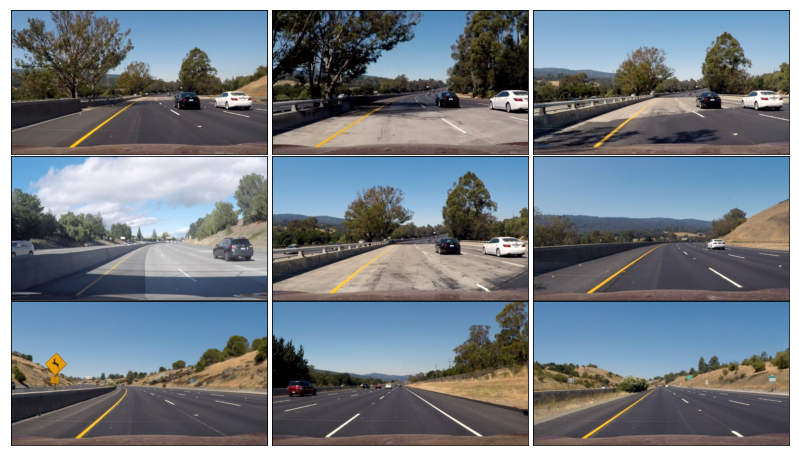

In [9]:
TEST_DIR = './test_images/'; fpaths = os.listdir(TEST_DIR)
test = [cv2.imread(TEST_DIR+fp, cv2.IMREAD_COLOR)[...,::-1] for fp in fpaths]
all(ax.imshow(im) for im,ax in zip(test, plt.subplots(3,3)[1].ravel()))

#### Apply Correction 

True

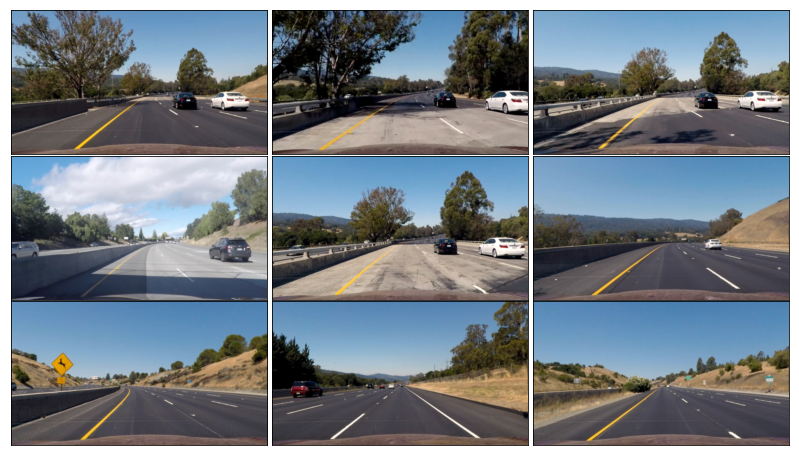

In [10]:
undist = list(cv2.undistort(img, mat,dist,None,camrmat) for img in test)
undist = list(map(lambda img: img[ymin:ymax,xmin:xmax], undist))
undist = list(map(lambda im: cv2.resize(im,(1280,720),interpolation=cv2.INTER_CUBIC), undist))
all(ax.imshow(im) for im,ax in zip(undist, plt.subplots(3,3)[1].ravel()))

### Illustration

True

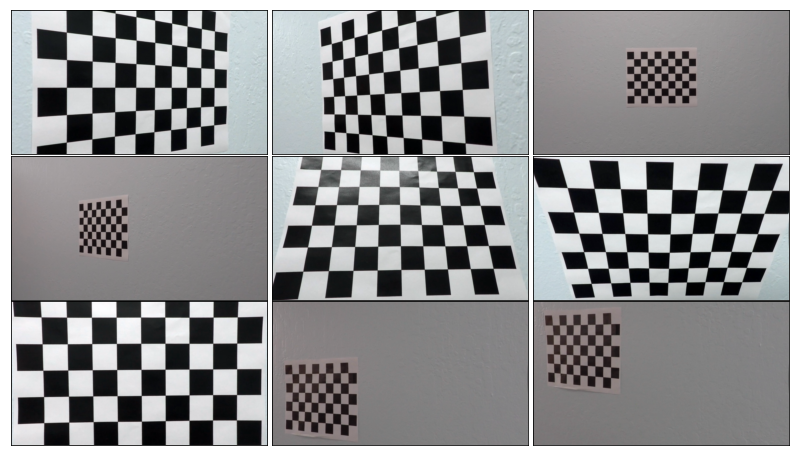

In [11]:
calib = list(cv2.undistort(img, mat,dist,None,camrmat) for img in imlist)
calib = list(map(lambda img: img[ymin:ymax,xmin:xmax], calib))
calib = list(map(lambda im: cv2.resize(im,(1280,720),interpolation=cv2.INTER_CUBIC), calib))
all(ax.imshow(im) for im,ax in zip(calib, plt.subplots(3,3)[1].ravel()))

### Color Space Transformation
We'll convert to the HSV colorspace to perform chroma based segmentation.
Intensity is sensitible to brightness variations, (e.g shadows, specular reflections).
These are also as-hard to separate in RGB space. 
Saturation is not sensitive to brightness variations, so using this channel alone often makes it hard to distinguish between distinct similary saturated colors. 

In [12]:
hsv = list(map(lambda im: cv2.cvtColor(im, cv2.COLOR_RGB2HSV), undist))

True

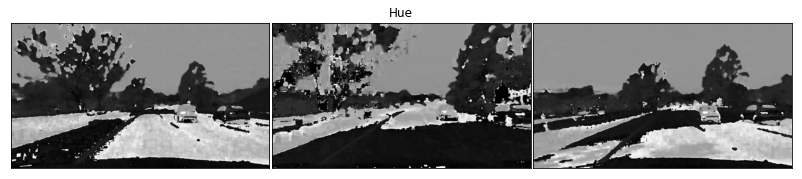

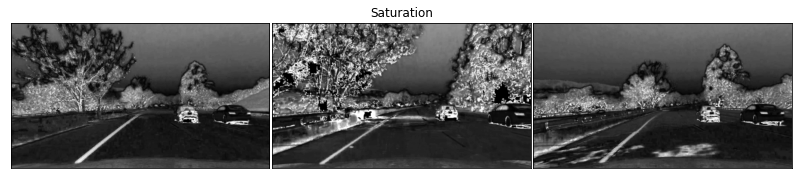

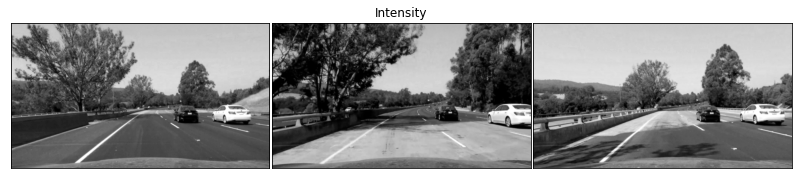

In [13]:
axlist = plt.subplots(1,3)[1]; axlist[1].set_title('Hue')
all(ax.imshow(im[...,0]) for im,ax in zip(hsv, axlist))
axlist = plt.subplots(1,3)[1]; axlist[1].set_title('Saturation')
all(ax.imshow(im[...,1]) for im,ax in zip(hsv, axlist))
axlist = plt.subplots(1,3)[1]; axlist[1].set_title('Intensity')
all(ax.imshow(im[...,2]) for im,ax in zip(hsv, axlist))

### Threshold Binarization
We apply binary thersholding based on HSV color ranges for both white and yellow lane lines. We OR the result to produce our single channel binary output image.

In [57]:
LOW_WHITE = np.array([0, 0, 223], dtype=np.uint8)
HIGH_WHITE = np.array([90,63,255], dtype=np.uint8)
LOW_YELLOW = np.array([15,127,223], dtype=np.uint8)
HIGH_YELLOW = np.array([30,255,255], dtype=np.uint8)

In [60]:
wmask = list(map(lambda im: cv2.inRange(im, LOW_WHITE, HIGH_WHITE),hsv))
ymask = list(map(lambda im: cv2.inRange(im, LOW_YELLOW, HIGH_YELLOW),hsv))
binary = list(map(lambda ymsk,wmsk: cv2.bitwise_or(ymsk, wmsk),ymask, wmask))

True

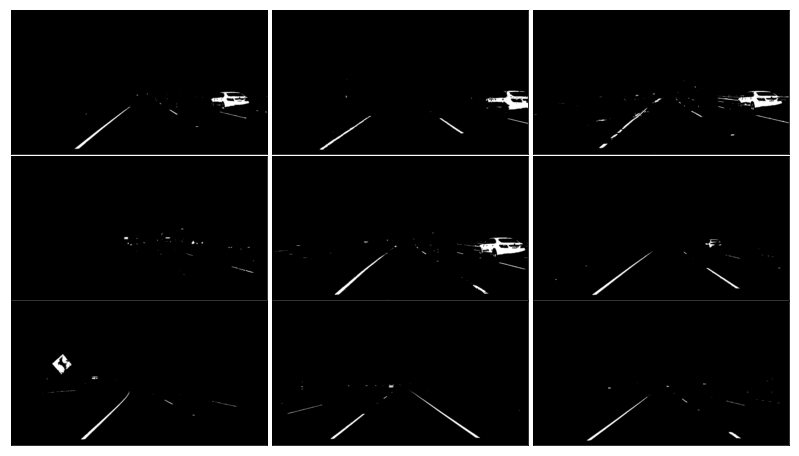

In [61]:
all(ax.imshow(im) for im,ax in zip(binary,plt.subplots(3,3)[1].ravel()))

## Perspective Transformation
We perform a perspective transformation such that the lane lines are parallel and the ROI fills the whole image. The transformation matrix is computed by finding the lane line endpoints from one of the curve-less test examples. The transformation destination points are the same points with their x coordinates values equalize (i.e lines become parallel).

In [62]:
# Load straight lane lines image
img = binary[7]
# lane line coordinates in a cropped box 
cords = np.argwhere(img>0); cords = cords[cords[:,0]> 575]
lcord, rcord = cords[cords[:,1] < 600], cords[cords[:,1] > 700]
lcord, rcord = lcord[lcord[:,1] > 320], rcord[rcord[:,1] < 1000]
# get lane line extrema coordinates
lmin, lmax = np.min(lcord, axis=0), np.max(lcord, axis=0)
rmin, rmax = np.min(rcord, axis=0), np.max(rcord, axis=0)
p0, p1 = (lmin[1], lmax[0]), (lmax[1], lmin[0])
p2, p3 = (rmin[1], rmin[0]), (rmax[1], rmax[0])

In [63]:
src = np.array([p0,p1,p2,p3], dtype=np.float32)
dst = np.array([p0, (p0[0],p1[1]), (p3[0],p2[1]), p3], dtype=np.float32)

#### Get Perspective Matrix

In [64]:
Mprsp = cv2.getPerspectiveTransform(src, dst)
iMprsp= cv2.getPerspectiveTransform(dst, src)

#### Apply Transformation

True

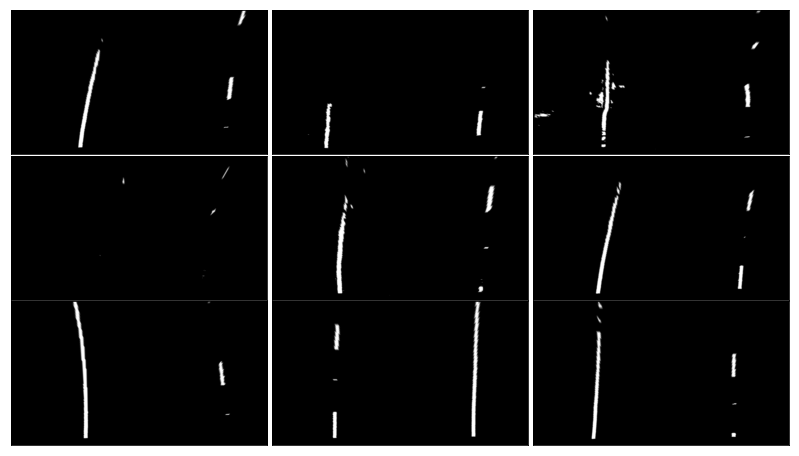

In [65]:
persp = list(map(lambda im: cv2.warpPerspective(im,Mprsp,(1280,720),cv2.INTER_CUBIC), binary))
all(ax.imshow(im) for im,ax in zip(persp, plt.subplots(3,3)[1].ravel()))

### Histogram Peaks
We perform a histogram peak search to find the lane line locations in the image.
This is implemented fully in the video pipeline. The idea is here is to search only around x coordinates with the most concentration of white pixels.

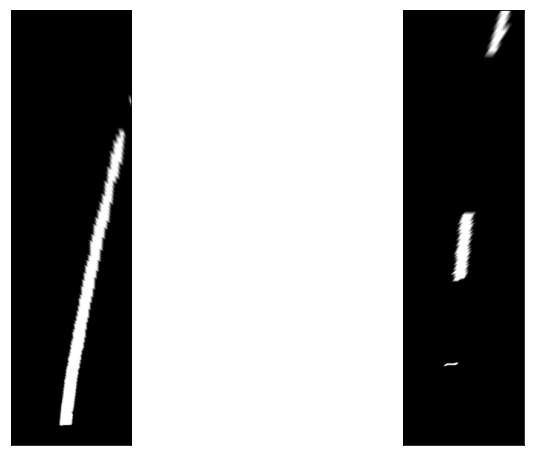

In [91]:
MARGIN = 100
img = persp[0].copy()
hist = np.sum(img, axis=0)
lhist, rhist = hist[:640], hist[640:]
lcenter, rcenter = np.argmax(lhist), np.argmax(rhist)+640
llo, lhi, rlo, rhi = lcenter-MARGIN, lcenter+MARGIN, rcenter-MARGIN, rcenter+MARGIN
plt.subplot(1,2,1).imshow(img[:,llo:lhi]); plt.subplot(1,2,2).imshow(img[:,rlo:rhi])

## Polynomial Fit
We divide the images into two halves containing each lanes. 
We then calculate the coordinates of each points in each half. 
Finally, we approximate a 2nd order polynomial function to fit the calculated points. 
`numpy.polyfit()` searches for a polynomial to fit the input points which minimzes the squared error $E = \sum_{j=0}^k |p(x_j) - y_j|^2$.

In [66]:
# get all nonzero point coordinates
contpts = list(map(lambda img: np.argwhere(img>0), persp))
# divide into left and right image side coordinates 
lconts = list(map(lambda pts: pts[pts[...,1]<640].T ,contpts))
rconts = list(map(lambda pts: pts[pts[...,1]>639].T ,contpts))
# if there are no points, puts some that make a straight line
lstrt, rstrt = np.array([[360,361,362],[320,320,320]]), np.array([[360,361,362],[960,960,960]])
lconts = list(map(lambda pts: pts if pts.any() else lstrt , lconts))
rconts = list(map(lambda pts: pts if pts.any() else rstrt , rconts))
# fit a polynomial for the input points of each image
lpoly = list(map(lambda pts: np.poly1d(np.polyfit(pts[0],pts[1],2)),lconts))
rpoly = list(map(lambda pts: np.poly1d(np.polyfit(pts[0],pts[1],2)),rconts))

In [67]:
# extrapolate lane line point coordinates by way of the computed polynomial
x = np.arange(0,720,100)
lpts = list(map(lambda lp: np.vstack((lp(x),x)).T.astype(np.int32), lpoly))
rpts = list(map(lambda rp: np.vstack((rp(x),x)).T.astype(np.int32), rpoly))

### Polynomials Fit Overlay
We draw the extrapolated polynomial line into a blank image. We then do an inverse-perspective transform on the overlay images to be able to blend them with the input images later.

In [68]:
overlay= []
for i in range(9):
    img = np.zeros((720,1280,3), dtype=np.uint8)
    img = cv2.polylines(img,[lpts[i]], isClosed=False, color=(255,255,255), thickness=43)
    img = cv2.polylines(img,[rpts[i]], isClosed=False, color=(255,255,255), thickness=43)
    pts = np.concatenate((lpts[i],rpts[i][::-1]))
    img = cv2.fillConvexPoly(img,pts,color=(0,0,193))
    img = cv2.warpPerspective(img,iMprsp,(1280,720),flags=cv2.INTER_CUBIC)
    overlay.append(img)

True

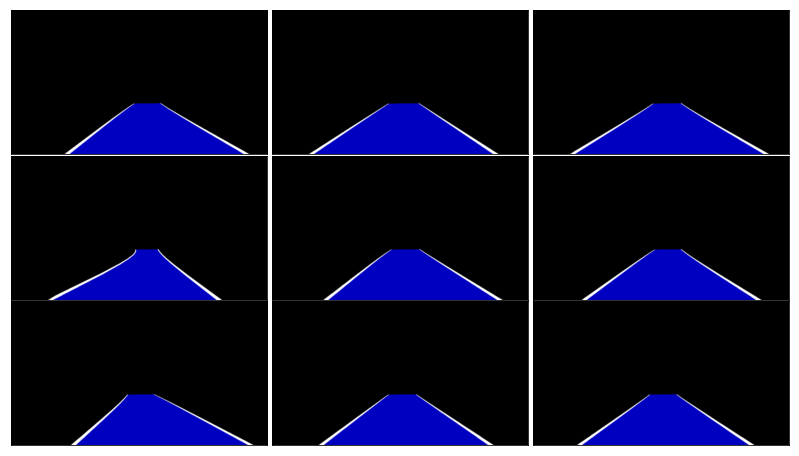

In [69]:
all(ax.imshow(im) for im,ax in zip(overlay, plt.subplots(3,3)[1].ravel()))

### Curvature Estimation
We'll calculate the curvature radius by way of the following formula:
$$ r(x) = { {\lvert 1+{f'(x)}^2 \rvert}^{3/2} \over {\lvert f''(x) \rvert}  }$$  

In [70]:
METERS_PER_VERTICAL_PIXEL = 30/720.
X_CENTER = 1280/2
radius = []
for i in range(9):
    lpolyder1 = lpoly[i].deriv(m=1); lpolyder2 = lpoly[i].deriv(m=2)
    rpolyder1 = rpoly[i].deriv(m=1); rpolyder2 = rpoly[i].deriv(m=2);
    lrad = (1+lpolyder1(X_CENTER)**2)**1.5/np.abs(lpolyder2(640))
    rrad = (1+rpolyder1(X_CENTER)**2)**1.5/np.abs(rpolyder2(640))
    rad = (lrad+rrad)*METERS_PER_VERTICAL_PIXEL/2
    rad = rad if rad<1000 else 999
    radius.append(rad)

### Lane Center Offset Estimation
Lane center is calculated as the mean of mean coordinates of each lane. 

In [71]:
METERS_PER_HORIZONTAL_PIXEL = 3.7/700.
offset = []
for i in range(9):
    center = (np.mean(rpts[i].T[0]) + np.mean(lpts[i].T[0]))/2
    offset.append((center - X_CENTER)*METERS_PER_HORIZONTAL_PIXEL)

### Text Overlay

In [72]:
curve_txt = list(map(lambda r: 'Curve radius: '+str(np.round(r,decimals=1))+'m', radius))
offset_txt = list(map(lambda ofst: 'Center offset: '+str(np.round(ofst,decimals=2))+'m', offset))

In [73]:
for ovr,ctxt,otxt in zip(overlay, curve_txt,offset_txt):
    cv2.putText(ovr, ctxt,(50, 75),cv2.FONT_HERSHEY_DUPLEX,2.718,(255, 255, 255),2)
    cv2.putText(ovr, otxt,(50, 150),cv2.FONT_HERSHEY_DUPLEX,2.718,(255, 255, 255),2)

In [74]:
output = list(map(lambda im,ov: np.maximum(im,ov), overlay,undist))

True

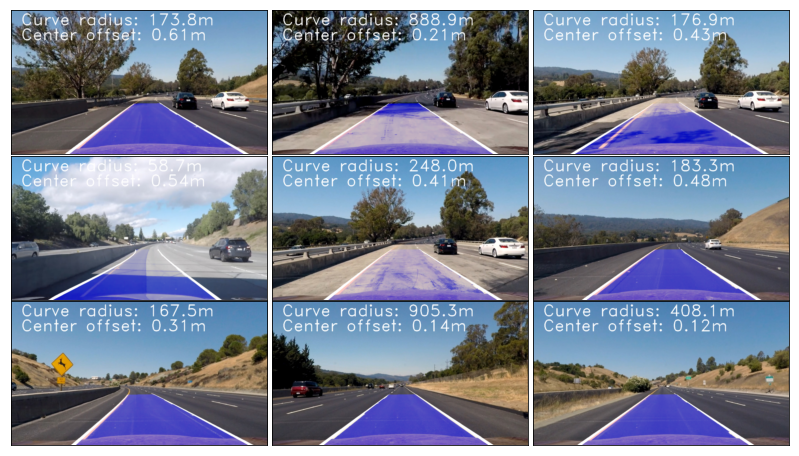

In [75]:
all(ax.imshow(im) for im,ax in zip(output, plt.subplots(3,3)[1].ravel()))

## Video Pipeline
The video pipeline is mostly identical to the above process. Major difference is the addition of rudimentary temporal high pass filtering and functional encapsulation.
Images are procesed per video frame. 

### Image Processing

In [676]:
def undistort(img):
    img = cv2.undistort(img, mat,dist,None,camrmat)
    img = img[ymin:ymax,xmin:xmax]
    img = cv2.resize(img,(1280,720),interpolation=cv2.INTER_NEAREST)
    return img

In [677]:
def binarize(img):
    img = img.astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    wmsk = cv2.inRange(img, LOW_WHITE, HIGH_WHITE)
    ymsk = cv2.inRange(img, LOW_YELLOW, HIGH_YELLOW)
    img = cv2.bitwise_or(ymsk, wmsk)
    img = cv2.warpPerspective(img,Mprsp,(1280,720),cv2.INTER_NEAREST)
    return img

### Histogram Peaks Window
We only consider the points within the histogram peak windows.

In [678]:
MARGIN = 50
def get_windows(img):
    hist = np.sum(img, axis=0)
    lhist, rhist = hist[:640], hist[640:]
    l_center, r_center = np.argmax(lhist), np.argmax(rhist)+640
    llo, lhi, rlo, rhi = l_center-MARGIN, l_center+MARGIN, r_center-MARGIN, r_center+MARGIN
    return llo, lhi, rlo, rhi

### Polynomial Fit

In [679]:
MIN_PIXEL_COUNT = 100

In [680]:
def fit_poly(img, lo, hi, old_pts):
    pts = np.argwhere(img>0)
    pts = pts[np.logical_and(pts[...,1]>lo, pts[...,1]<hi)].T
    pts = pts if pts.shape[1]>MIN_PIXEL_COUNT or old_pts is None else old_pts
    poly = np.poly1d(np.polyfit(pts[0],pts[1],2))
    return poly

#### Temporal Filtering
Instead of just taking the raw calculated values, we reject overly large changes and smooth over smaller ones.

In [681]:
def filter_poly(lpoly, rpoly, old_lpoly, old_rpoly):
    # error checks 
    if old_rpoly is None or old_lpoly is None:
        return lpoly,rpoly
    # calc differences from last frame poly
    ldif, rdif = np.abs(lpoly-old_lpoly), np.abs(rpoly-old_rpoly)
    if ldif.shape[0]<2 or rdif.shape[0]<2:
        return lpoly,rpoly
    # interpoalte left polynomial
    lpoly = old_lpoly if ldif[0]>0.001 or ldif[1]>1 or ldif[2]>320 else 0.3*lpoly+0.7*old_lpoly
    # interpoalte right polynomial
    rpoly = old_rpoly if rdif[0]>0.001 or rdif[1]>1 or rdif[2]>320 else 0.3*rpoly+0.7*old_rpoly
    return lpoly,rpoly

### Line Extrapolation

In [682]:
def extrapolate(poly):
    x = np.arange(0,720,100)
    pts = np.vstack((poly(x),x)).T.astype(np.int32)
    return pts

### Radius and Offset Calculations
The radius is also interpolated over time.

In [683]:
def calc_radius(lpoly, rpoly, old_radius):
    lderiv1, lderiv2 = lpoly.deriv(m=1), lpoly.deriv(m=2)
    rderiv1, rderiv2 = rpoly.deriv(m=1), rpoly.deriv(m=2)
    lrad = (1+lderiv1(X_CENTER)**2)**1.5/np.abs(lderiv2(640))
    rrad = (1+rderiv1(X_CENTER)**2)**1.5/np.abs(rderiv2(640))
    rad = (lrad+rrad)*METERS_PER_VERTICAL_PIXEL/2
    rad = rad if old_radius is None else 0.1*rad+old_radius*0.9
    return rad

In [684]:
BOTTOM_THIRD = 480
def calc_offset(lpts, rpts):
    xcntr = 0.5*(np.mean(lpts[lpts[:,1]>BOTTOM_THIRD]) + np.mean(rpts[rpts[:,1]>BOTTOM_THIRD]))
    ofst = (xcntr - X_CENTER)*METERS_PER_HORIZONTAL_PIXEL
    return ofst

In [685]:
def radius_text(radius):
    rad_txt = 'Curve radius: ' + str(np.round(radius,decimals=1)) + 'm'
    return rad_txt

In [686]:
def offset_text(offset):
    ofs_txt = 'Center offset: '+ str(np.round(offset,decimals=2)) + 'm'
    return ofs_txt

### Drawing Functions

In [687]:
def draw_text(img, offset, radius):
    rad_txt, ofs_txt = radius_text(radius), offset_text(offset)
    cv2.putText(img, rad_txt,(50, 70),cv2.FONT_HERSHEY_DUPLEX,2,(255, 255, 255),2)
    cv2.putText(img, ofs_txt,(50, 140),cv2.FONT_HERSHEY_DUPLEX,2,(255, 255, 255),2)
    return img

In [688]:
def draw_lanes(img, lpts, rpts):
    ovr = np.zeros((720,1280,3), dtype=np.int32)
    ovr = cv2.polylines(ovr,[lpts], isClosed=False, color=(255,255,255), thickness=63)
    ovr = cv2.polylines(ovr,[rpts], isClosed=False, color=(255,255,255), thickness=63)
    ovr = cv2.fillConvexPoly(ovr,np.concatenate((lpts,rpts[::-1])),color=(0,0,193))
    ovr = cv2.warpPerspective(ovr,iMprsp,(1280,720),flags=cv2.INTER_NEAREST)
    img = np.maximum(img, ovr)
    return img

### Image Processing Main Functions

In [691]:
def process(img):
    img = undistort(img)
    binary = binarize(img)
    llo, lhi, rlo, rhi = get_windows(binary)
    # fit polynomials
    left_poly = fit_poly(binary,llo, lhi, process.old_left_points)
    right_poly = fit_poly(binary,rlo,rhi, process.old_right_points)
    left_poly, right_poly = filter_poly(left_poly,right_poly, process.old_left_poly, process.old_right_poly)
    # extrapolate lane points
    left_points, right_points = extrapolate(left_poly), extrapolate(right_poly)
    radius = calc_radius(left_poly, right_poly, process.old_radius)
    offset = calc_offset(left_points,right_points)
    # draw 
    img = draw_text(img, offset, radius)
    img = draw_lanes(img, left_points,right_points)
    # update filter params
    process.old_left_poly, process.old_right_poly = left_poly, right_poly
    process.old_left_points, process.old_right_points = left_points, right_points
    process.old_radius=radius
    return img

process.old_left_points = None
process.old_right_points = None
process.old_left_poly = None
process.old_right_poly = None
process.old_radius = None

### Video Frame Extraction

#### Project Video

In [692]:
video = VideoFileClip("project_video.mp4")
processed_video = video.fl_image(process)
processed_video.write_videofile("output_video.mp4", audio=False, progress_bar=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 



## Discussion

The model is sensitive to a variety of variables: day/night conditions, shadows, specular reflections, traffic, steep inclines and declines, partial or total lack of markings, weather artifacts, and many others.  

There's definitely a lot of work that can be done further. For example, ensemble methods like combining edge detection and chroma segmentation result. Or advanced temporal methods looking at various changes over time. 